## Rotational Broadening
Broadening via rotational kernel as defined in Gray (1976) and Gray (2005), see [Background](#background) for more details.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from broadpy import RotationalBroadening
from broadpy.utils import load_example_data

%load_ext autoreload
%autoreload 2

In [2]:
# load PHOENIX model (R~1e6)
wave, flux = load_example_data()

In [3]:
# pyasl fastRotBroad
import PyAstronomy.pyasl as pyasl

vsini = 10.0 # km/s
eps = 0.5 # limb darkening coefficient
flux_pyasl = pyasl.fastRotBroad(wave, flux, epsilon=eps, vsini=vsini)

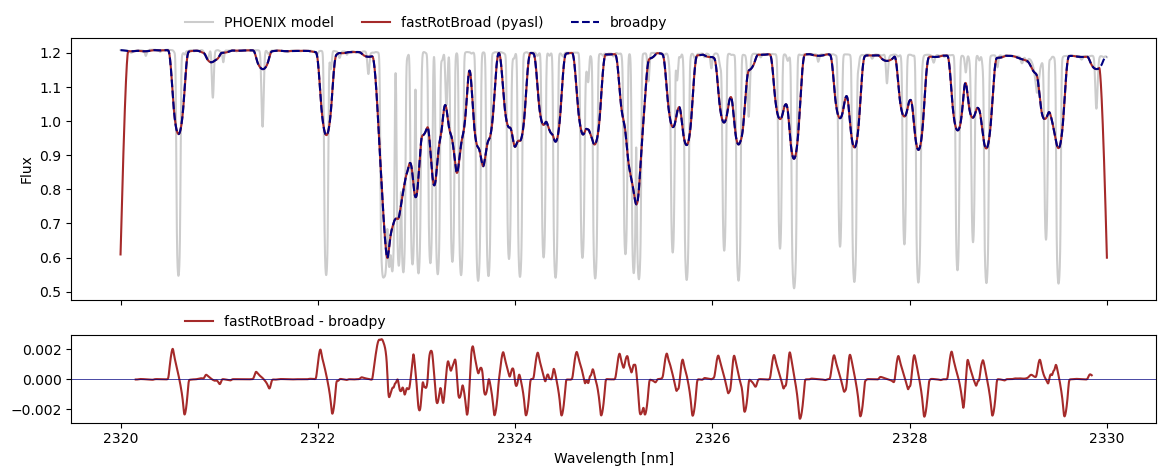

In [6]:
RB = RotationalBroadening(wave, flux)
flux_rotbroad = RB(vsini=vsini, epsilon=eps)
# plot the original spectrum
fig, ax = plt.subplots(2, 1, figsize=(14, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(wave, flux, label='PHOENIX model', alpha=0.2, color='black')

ax[0].plot(wave, flux_pyasl, label='fastRotBroad (pyasl)', color='brown')

ax[0].plot(wave, flux_rotbroad, label='broadpy', color='navy', ls='--')

residuals = flux_pyasl - flux_rotbroad

c = 299792.458 # km/s
n_edge = 2 * int(np.mean(wave) / np.mean(np.diff(wave)) / (c/vsini))
residuals[:n_edge] = residuals[-n_edge:] = np.nan

ax[1].plot(wave, residuals, color='brown', label='fastRotBroad - broadpy')
ax[1].axhline(0, color='navy', linestyle='-', lw=0.5)
ax[1].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Flux')
[ax_.legend(ncol=3, loc=(0.1, 1.01), frameon=False) for ax_ in ax]
plt.show()

In [5]:
# speed comparison
speed_test = True

if speed_test:
    %timeit pyasl.fastRotBroad(wave, flux, epsilon=eps, vsini=vsini)
    %timeit RB(vsini=vsini, epsilon=eps)

783 μs ± 11.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
606 μs ± 7.58 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Background
### 1. Defining the Rotational Broadening Kernel

The rotational broadening profile, also known as the Gray profile, models how stellar rotation affects the observed spectral lines. The kernel function $ G(v) $ is defined as:

$$
G(v) = \frac{2(1 - \epsilon)\sqrt{1 - \left(\frac{v}{v_{\text{max}}}\right)^2} + \frac{\pi}{2} \epsilon \left(1 - \left(\frac{v}{v_{\text{max}}}\right)^2 \right)}{\pi v_{\text{max}} (1 - \frac{\epsilon}{3})}
$$

where:

- $ v $ is the velocity shift corresponding to a wavelength shift from the reference wavelength.
- $ v_{\text{max}} = v \sin i $ is the maximum Doppler shift due to rotation.
- $ \epsilon $ is the limb-darkening coefficient, which accounts for the variation in brightness from the center to the edge of the stellar disk.

### 2. Simplified Kernel Equation

For computational purposes, this can be simplified into two constants:

$$
G(v) = \begin{cases} 
\frac{2(1 - \epsilon)}{\pi v_{\text{max}} (1 - \frac{\epsilon}{3})} \sqrt{1 - \left(\frac{v}{v_{\text{max}}}\right)^2} + \frac{\epsilon}{2v_{\text{max}} (1 - \frac{\epsilon}{3})} \left(1 - \left(\frac{v}{v_{\text{max}}}\right)^2 \right), & \text{if } |v| \leq v_{\text{max}} \\
0, & \text{otherwise}
\end{cases}
$$

This equation defines the rotational broadening profile over a range of velocities, which corresponds to a range of wavelengths when applied to spectral data.